100%|██████████| 1/1 [00:04<00:00,  4.60s/it]


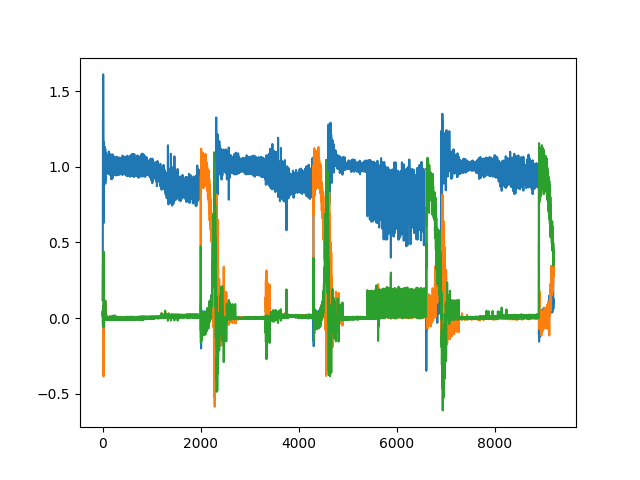

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from norse.torch.functional.lif_adex import LIFAdExParameters
from norse.torch.functional.lif_adex_refrac import LIFAdExRefracParameters

from tqdm import tqdm
from cgtasknet.net.lifadexrefrac import SNNlifadexrefrac
from cgtasknet.instruments.instrument_pca import PCA

from cgtasknet.net.states import LIFAdExRefracInitState
from cgtasknet.tasks.reduce import (
    DMTaskParameters,
    DMTask,
)

all_answ_time = .3
all_trial_time = 2.
dmparams1 = DMTaskParameters(
    trial_time=all_trial_time, value=0, answer_time=all_answ_time
)

dmparams2 = DMTaskParameters(
    trial_time=all_trial_time, value=.3, answer_time=all_answ_time
)

dmparams3 = DMTaskParameters(
    trial_time=all_trial_time,  value=.6, answer_time=all_answ_time
)

dmparams4 = DMTaskParameters(
    trial_time=all_trial_time,  value=1, answer_time=all_answ_time
)

Task = DMTask(dmparams1, mode="value")

Task2 = DMTask(dmparams2, mode="value")

Task3 = DMTask(dmparams3, mode="value")

Task4 = DMTask(dmparams4, mode="value")

feature_size = 4
output_size = 3
hidden_size = 450
batch_size = 1
tau_ada_inv_distrib = np.load('..\\..\\..\\models\\dm_and_romo\\lif_adex_refrac\\dm_and_romo_reduce_adex_refrac_450_95_percents_2000_epochs_alpha=100.npy')
rule_matrix = np.zeros((int((dmparams1.trial_time + dmparams1.answer_time) / dmparams1.dt), 1, 2))
rule_matrix[:, :, 0] = 1
neuron_parameters = LIFAdExRefracParameters(
    LIFAdExParameters(
        v_th=torch.as_tensor(0.65),
        tau_ada_inv=torch.from_numpy(tau_ada_inv_distrib),
        alpha=20,
        # method='heavi_erfc',
        method="super",
    ),
    rho_reset=torch.as_tensor(1),
    # rho_reset = torch.as_tensor(5)
)
model = SNNlifadexrefrac(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
    save_states = True,
)
if True:
    model.load_state_dict(
        torch.load('..\\..\\..\\models\\dm_and_romo\\lif_adex_refrac\\dm_and_romo_reduce_adex_refrac_450_95_percents_2000_epochs_alpha=100')
    )

init_state = LIFAdExRefracInitState(batch_size, hidden_size)
first_state = init_state.zero_state()
second_state = init_state.random_state()
inputs, target_out = Task.dataset(1)
one_trajectory_time = inputs.shape[0] * 4 # - 2 + 1500 + 1500
v_mean = torch.zeros((one_trajectory_time,  hidden_size * 2 ))
a_mean = torch.zeros((one_trajectory_time,  hidden_size * 2 ))
number_of_trials = 1
#states_generator = SNNStates(model)
inputs1, target_out = Task.dataset(1)
inputs1 = np.concatenate((inputs1, rule_matrix), axis=2)
inputs1 = torch.from_numpy(inputs1).type(torch.float)

inputs2, target_out2 = Task2.dataset(1)
inputs2= np.concatenate((inputs2, rule_matrix), axis=2)

inputs2 = torch.from_numpy(inputs2).type(torch.float)



inputs3, target_out3 = Task3.dataset(1)
inputs3 = np.concatenate((inputs3, rule_matrix), axis=2)

inputs3 = torch.from_numpy(inputs3).type(torch.float)

inputs4, target_out4 = Task4.dataset(1)
inputs4= np.concatenate((inputs4, rule_matrix), axis=2)

inputs4 = torch.from_numpy(inputs4).type(torch.float)
data = torch.concat((inputs1, inputs2, inputs3, inputs4))

for trial in tqdm(range(number_of_trials)):
    second_state = init_state.zero_state()
    

    out, states = model(data, second_state)

    v = []
    s = []
    i = []
    a = []
    for j in range(len(states)):
        v.append(states[j].lif_adex.v)
        s.append(states[j].lif_adex.z)
        i.append(states[j].lif_adex.i)
        a.append(states[j].lif_adex.a)

    s = torch.stack(s).detach()
    v = torch.stack(v).detach()
    a = torch.stack(a).detach()
    v_mean[:,  :hidden_size] += v[:, 0, :]
    a_mean[:,  :hidden_size] += a[:, 0, :]
    #v_mean[:, hidden_size:] += a[:, 0, :]
v_mean /= float(number_of_trials)
a_mean /= float(number_of_trials)
pca = PCA(3).decompose(v_mean.reshape(v_mean.shape[0], v_mean.shape[1]))
pca_a = PCA(3).decompose(a_mean.reshape(a_mean.shape[0], a_mean.shape[1]))
cmap = np.arange(0, len(v_mean))
data = np.concatenate((inputs1, inputs2, inputs3, inputs4))

%matplotlib widget
zeros_array = np.zeros((0, 1, 3))
plt.figure()
plt.plot(out[:, 0,  :].detach().cpu().numpy()[:, 0])
plt.plot(out[:, 0, :].detach().cpu().numpy()[:, 1])
plt.plot(out[:, 0, :].detach().cpu().numpy()[:, 2])

plt.show()



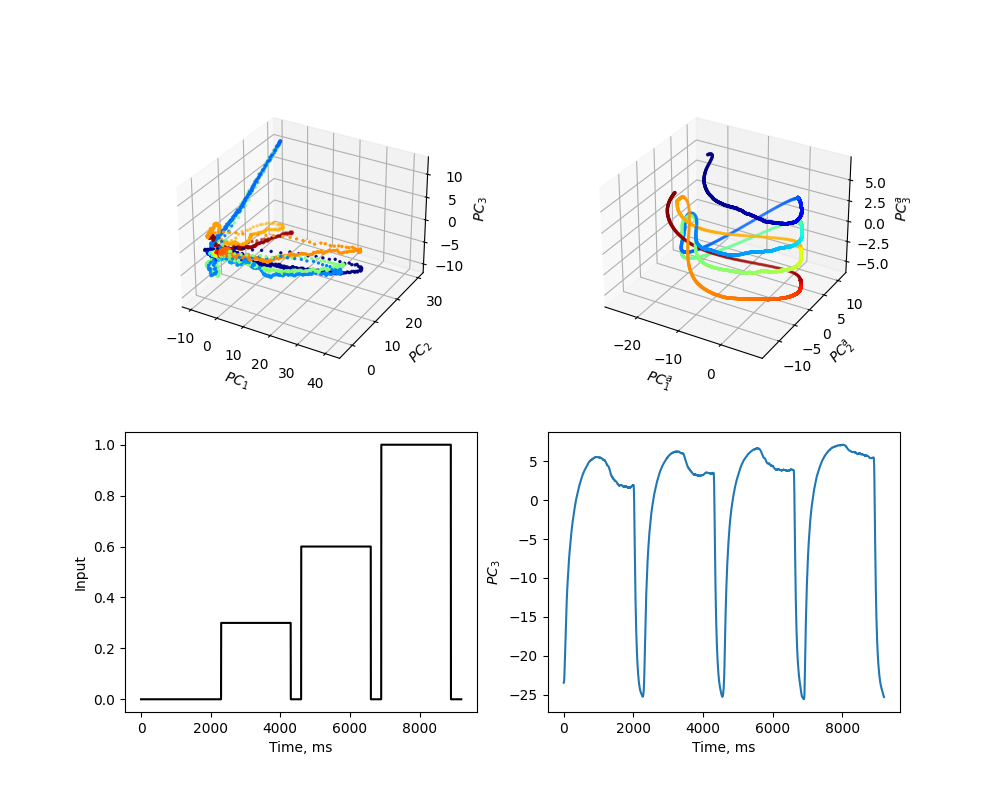

In [2]:
plt.ion
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(221, projection="3d")

ax2 = fig.add_subplot(223)

(line,) = ax.plot(1, 1)
(line2,) = ax.plot(1, 1)
fig.canvas.draw()
fig.canvas.flush_events()

ax3 = fig.add_subplot(222, projection="3d")
ax4 = fig.add_subplot(224)
# plt.tight_layout()

first = 0
second = 1
third = 2

# plt.clf()
ax.set_xlim(-40, 12)
ax.set_ylim(-18, 18)

ax2.set_xlim([0, len(pca)])
ax2.set_ylim([-0.5, 1.5])
ax.clear()
ax2.clear()
ax3.clear()
ax4.clear()

ax.scatter(
    pca.numpy()[:, first],
    pca.numpy()[:, second],
    pca.numpy()[:, third],
    cmap="jet",
    c=[*range(pca.numpy().shape[0])],
    s=2,
)

ax2.plot(data[:, 0, 1], c="black")
ax3.scatter(
    pca_a.numpy()[:, first],
    pca_a.numpy()[:, second],
    pca_a.numpy()[:, third],
    cmap="jet",
    c=[*range(pca.numpy().shape[0])],
    s=2,
)

ax4.plot(
    pca_a.numpy()[:, first],
)

ax.set_xlabel("$PC_1$")
ax.set_ylabel("$PC_2$")
ax.set_zlabel("$PC_3$")
ax2.set_xlabel("Time, ms")
ax2.set_ylabel("Input")
ax3.set_xlabel("$PC^a_1$")
ax3.set_ylabel("$PC^a_2$")
ax3.set_zlabel("$PC^a_3$")
ax4.set_xlabel("Time, ms")
ax4.set_ylabel("$PC_3$")

fig.canvas.draw()
fig.canvas.flush_events()
# time.sleep(.001)


# while True:

plt.show()

In [11]:
import time

start = 0
step = 20
plot_step = 20
c = [i in range(start, len(pca), step)]


def update():

    for i in range(start, len(pca), step):

        first = 0
        second = 1
        third = 2

        # plt.clf()
        ax.set_xlim(-40, 12)
        ax.set_ylim(-18, 18)

        ax2.set_xlim([0, len(pca)])
        ax2.set_ylim([-0.5, 1.5])
        ax.clear()
        ax2.clear()
        ax3.clear()
        ax4.clear()

        ax.scatter(
            pca.numpy()[start:i:plot_step, first],
            pca.numpy()[start:i:plot_step, second],
            pca.numpy()[start:i:plot_step, third],
            cmap="jet",
            c=[j for j in range(0, i - start, plot_step)],
            s=2,
        )

        ax2.plot(data[start:i, 0, 1], c="black")
        ax3.scatter(
            pca_a.numpy()[start:i:plot_step, first],
            pca_a.numpy()[start:i:plot_step, second],
            pca_a.numpy()[start:i:plot_step, third],
            cmap="jet",
            c=[j for j in range(0, i - start, plot_step)],
            s=2,
        )

        ax4.plot(out[start:i:plot_step, 0, :].detach().cpu().numpy()[:, 0])
        ax4.plot(out[start:i:plot_step, 0, :].detach().cpu().numpy()[:, 1])
        ax4.plot(out[start:i:plot_step, 0, :].detach().cpu().numpy()[:, 2])
        ax.set_xlabel("$PC_1$")
        ax.set_ylabel("$PC_2$")
        ax.set_zlabel("$PC_3$")
        ax2.set_xlabel("Time, ms")
        ax2.set_ylabel("Input")
        ax3.set_xlabel("$PC^a_1$")
        ax3.set_ylabel("$PC^a_2$")
        ax3.set_zlabel("$PC^a_3$")
        ax4.set_xlabel("Time, ms")
        ax4.set_ylabel("$PC_3$")

        fig.canvas.draw()
        fig.canvas.flush_events()
        # time.sleep(.001)


# while True:
update()

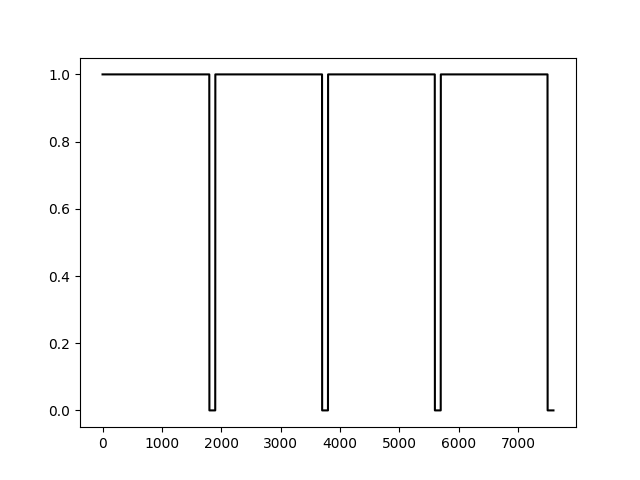

In [14]:
plt.figure()
plt.plot(data[:, 0, 0], c="black")

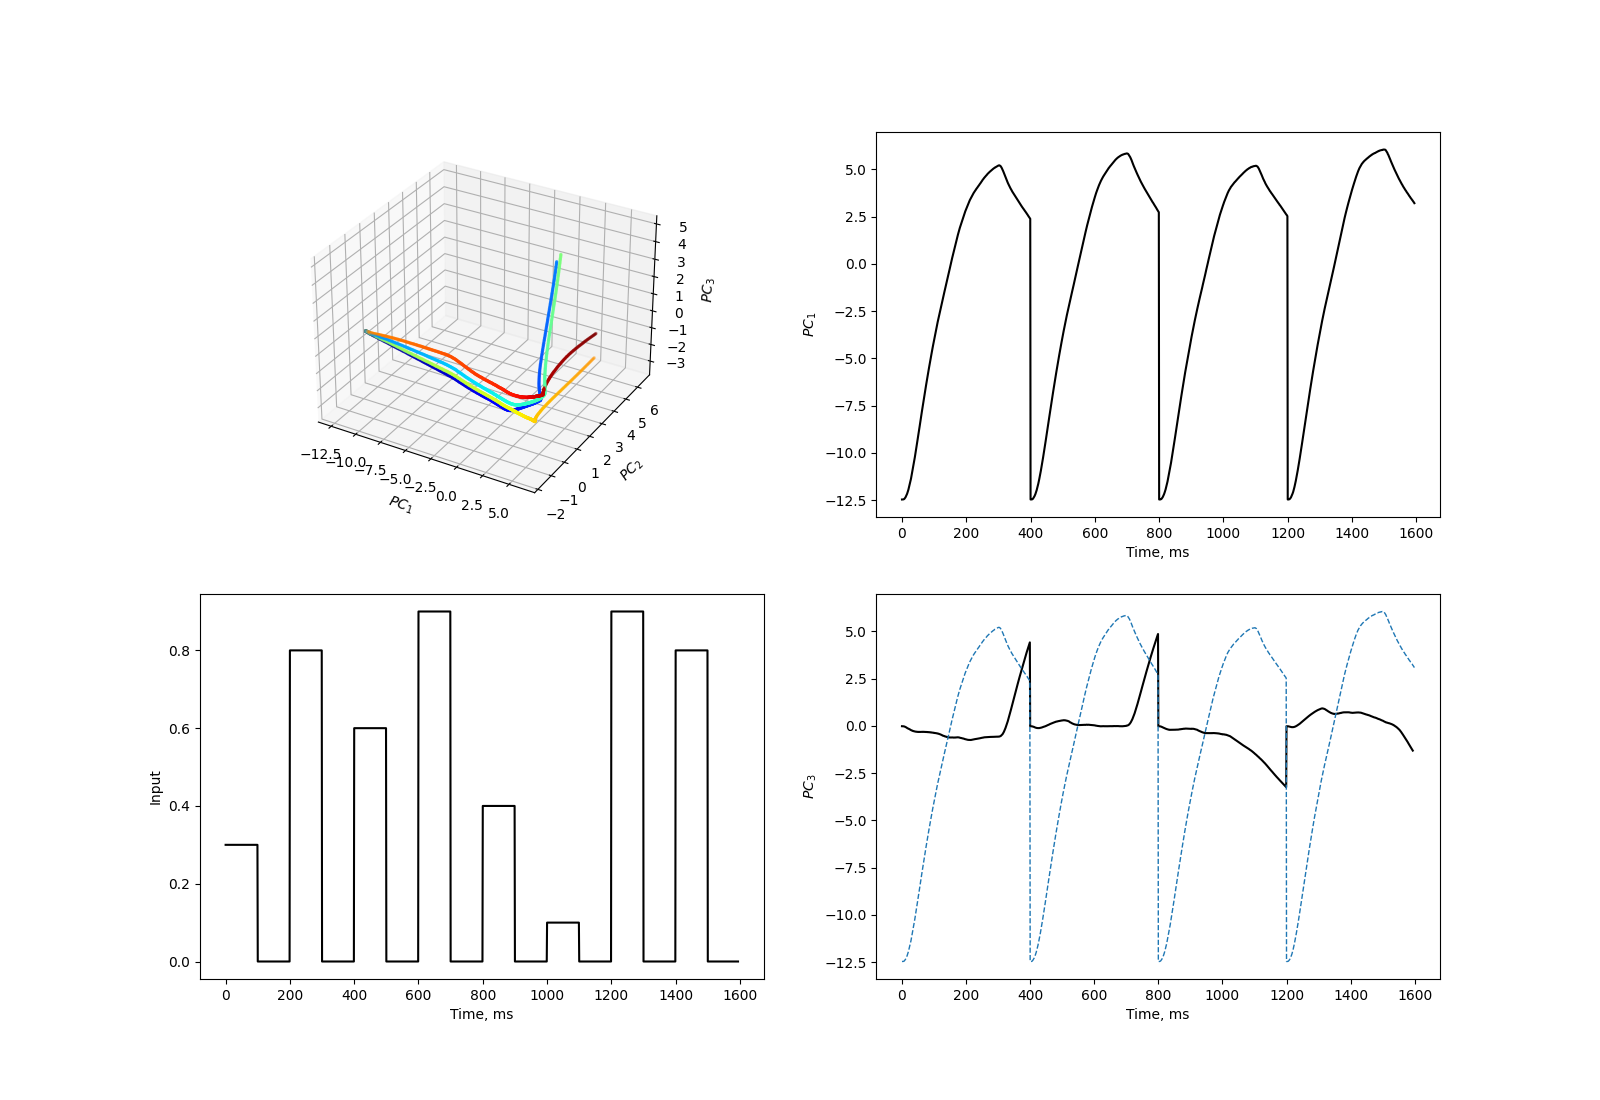

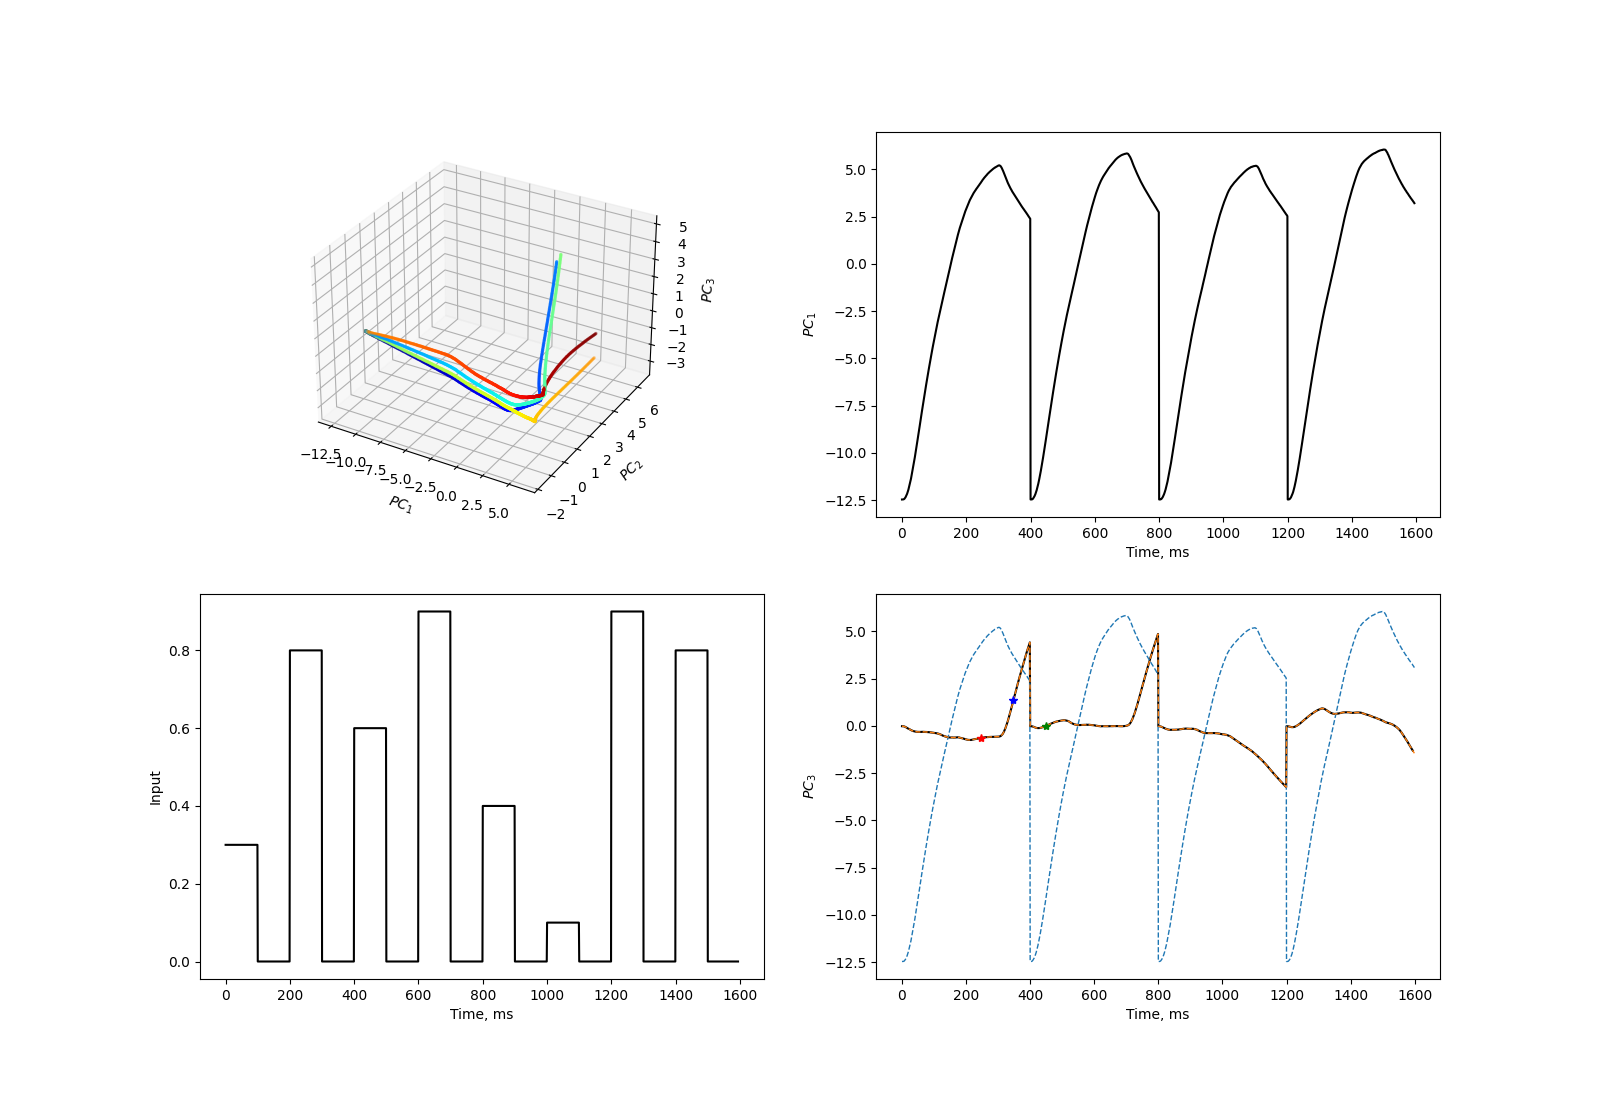

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
plt.plot(pca.numpy()[:, 0], "--", linewidth=1)
plt.show()
pca_show = 2
plt.plot(pca.numpy()[:, pca_show], "--", linewidth=1)
trialstop = 250
delay = 100
delay_beetween = 100
time = trialstop - 2
for i in range(1):

    plt.plot([time], pca.numpy()[time, pca_show], "*", c="r")
    time += delay
    plt.plot(
        [time],
        pca.numpy()[time, pca_show],
        "*",
        c="b",
    )
    time += delay_beetween
    plt.plot(
        [time],
        pca.numpy()[time, pca_show],
        "*",
        c="g",
    )
    time += trialstop
plt.show()
plt.close()

plt.imshow(v_mean.numpy()[:, 0, :].T, aspect="auto", origin="lower")
plt.show()

inputs, target_out = Task.dataset(1)

plt.plot(data[:, 0, 1].detach().cpu().numpy())
plt.show()

# plt.plot(out[:, 0, 0])
plt.plot(out[:, 0, 1])
plt.plot(out[:, 0, 2])
plt.show()

s = torch.stack(s).detach()
s = s.cpu().numpy()

plt.imshow(s[:, 0, :].T, aspect="auto", origin="lower")
plt.colorbar()
plt.show()

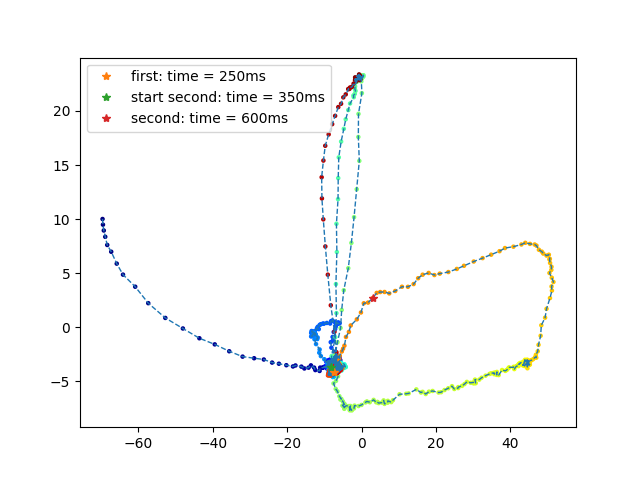

In [ ]:

%matplotlib widget

first = 0
second = 1
plt.plot(pca.numpy()[:, first], pca.numpy()[:, second], "--", linewidth=1)
plt.scatter(pca.numpy()[:, first], pca.numpy()[
            :, second], c=cmap, cmap="jet", s=5)


trialstop = 250
delay = 100
delay_beetween = 100
time = trialstop
for i in range(1):

    plt.plot(
        pca.numpy()[time, first],
        pca.numpy()[time, second],
        "*",
        label=fr"first: time = {time}ms",
    )
    time += delay
    plt.plot(
        pca.numpy()[time, first],
        pca.numpy()[time, second],
        "*",
        label=fr"start second: time = {time}ms",
    )
    time += trialstop
    plt.plot(
        pca.numpy()[time, first],
        pca.numpy()[time, second],
        "*",
        label=fr"second: time = {time}ms",
    )


plt.legend()
plt.show()
plt.close()


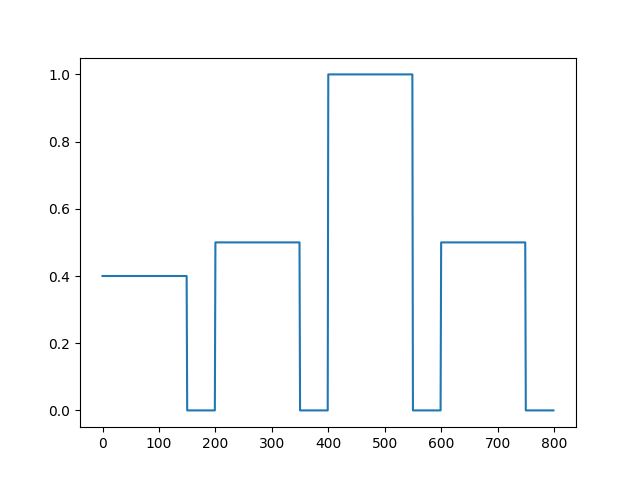

In [ ]:
plt.plot(data.cpu().numpy()[:, 0, 1])

In [ ]:
from norse.torch.module.exp_filter import ExpFilter


class EXPtest(torch.nn.Module):
    def __init__(self):
        super(EXPtest, self).__init__()

        self.f = ExpFilter(1, 1, 500, bias=False)

    def forward(self, x):
        return self.f(x)


data = torch.zeros((10, 1, 1))
data[0, :] = 1
l = EXPtest()
l(data)

tensor([[[-0.3520]],

        [[-0.2135]],

        [[-0.1295]],

        [[-0.0785]],

        [[-0.0476]],

        [[-0.0289]],

        [[-0.0175]],

        [[-0.0106]],

        [[-0.0064]],

        [[-0.0039]]], grad_fn=<StackBackward0>)